In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn import preprocessing
import pyodbc
import pickle
import math
import time
import warnings
import os
import sys

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
sys.setrecursionlimit(10000)

In [2]:
#Loading the data from model table in SQL Server

sql_conn = pyodbc.connect("DSN=CNPPEDW05")

sql = "select * from Analytics_RPT.dbo.DTC_SBR_PortfolioLoanSegment_Training_Data"

df = pd.read_sql(sql, sql_conn)

df.shape

(2355939, 63)

In [3]:
df.head()

,loan_num_srvcr,AsOfDt,FundDt,OrigLoanType,OrigLoanRefiPurpose,lien_position,term_orig,term_remaining,HomePriceAppreciation,CurrentPIPmt,CurrRate,orig_dt,orig_LTV,Val_waterfall,PropState,OccType,PropType,VintageYear,bal_orig,delq_days_mba,borrw_mail_state,YearBuilt,Year Built,prop_yr_blt,FICO,FTHBFlag,HomeEquityAmt,BenefitFlag_Prev_90_days,BenefitCategory_Prev_90_days,cd_bill_meth,OrigChannel,prop_NumberOfUnits,LandSquarefeet,Land Squarefeet,LandValue,IsNewConstruction,IsPropertyInspectionWaived,serv_NumberOfBedrooms,inf_NumberOfBedrooms,serv_NumberOfBathrooms,inf_NumberOfBathrooms,IsSpecOrModelHome,NumberOfFinancedProperties,Delq30In6,Delq30In12,Delq30In24,Delq60In6,Delq60In12,Delq60In24,OrigLoanPurpose,OrigLoanDocType,CombinedMonthlyIncomeH2O,AccountAssetsH2O,OtherAssetsH2O,OrigLoanDTI,TotalNetWorth,prevailing_rate_curr,prevailing_rate_orig,refi_flag,PifDate,refinance_flag,refi2_flag,refi3_flag
0,9500008694,2021-05-31,None,Conventional,N/A,1,240,15.0,0.520833,247.05,8.63,2002-09-09,58.75,25000.0,OK,owner occupied,Single Family,2002,28200.0,-12,OK,NaN,None,NaN,684,None,22789.59,0,No Info Available,1,Acquired,NaN,NaN,None,NaN,None,None,NaN,None,NaN,None,None,NaN,1,2,3,0,0,0,None,None,0.0000,0.0,0.0,NaN,0.0,3.12,8.63,0,None,NaN,0,0
1,9500008694,2021-03-31,None,Conventional,N/A,1,240,17.0,0.520833,247.05,8.63,2002-09-09,58.75,25000.0,OK,owner occupied,Single Family,2002,28200.0,-12,OK,NaN,None,NaN,684,None,22332.23,0,No Info Available,1,Acquired,NaN,NaN,None,NaN,None,None,NaN,None,NaN,None,None,NaN,2,2,3,0,0,0,None,None,0.0000,0.0,0.0,NaN,0.0,3.42,8.63,0,None,NaN,0,0
2,9500008694,2021-01-31,None,Conventional,N/A,1,240,19.0,0.520833,247.05,8.63,2002-09-09,58.75,25000.0,OK,owner occupied,Single Family,2002,28200.0,-12,OK,NaN,None,NaN,684,None,21881.37,0,No Benefit,1,Acquired,NaN,NaN,None,NaN,None,None,NaN,None,NaN,None,None,NaN,2,3,4,0,0,0,None,None,0.0000,0.0,0.0,NaN,0.0,2.80,8.63,0,None,NaN,0,0
3,9500009007,2021-07-31,None,Conventional,N/A,1,360,135.0,1.079365,686.85,7.24,2002-08-02,79.99,136000.0,TX,Owner Occupied,PUD,2002,100786.0,-6,TX,1966.0,1966,NaN,700,None,69161.33,0,No Benefit,1,Acquired,NaN,NaN,6825,91875.0,None,None,NaN,3,NaN,200,None,NaN,0,0,0,0,0,0,None,None,18083.3333,0.0,0.0,NaN,0.0,2.84,7.24,0,2021-09-13,1.0,1,1
4,9500009007,2021-03-31,None,Conventional,N/A,1,360,139.0,1.079365,686.85,7.24,2002-08-02,79.99,136000.0,TX,Owner Occupied,PUD,2002,100786.0,-6,TX,1966.0,1966,NaN,713,None,68043.87,0,No Info Available,1,Acquired,NaN,NaN,6825,91875.0,None,None,NaN,3,NaN,200,None,NaN,0,0,0,0,0,0,None,None,10250.0000,0.0,0.0,NaN,0.0,3.42,7.24,0,2021-09-13,1.0,0,0


In [4]:
df['AsOfDt'].value_counts()

2020-12-31    306797
2021-01-31    304932
2021-02-28    300319
2021-03-31    294655
2021-04-30    288150
2021-05-31    288087
2021-06-30    286744
2021-07-31    286255
Name: AsOfDt, dtype: int64

In [5]:
df['prop_NumberOfUnits'].value_counts()

1.0    1864050
2.0      39697
3.0       8440
4.0       5775
Name: prop_NumberOfUnits, dtype: int64

In [6]:
df[['AsOfDt','orig_dt']].head()

,AsOfDt,orig_dt
0,2021-05-31,2002-09-09
1,2021-03-31,2002-09-09
2,2021-01-31,2002-09-09
3,2021-07-31,2002-08-02
4,2021-03-31,2002-08-02


In [7]:
((pd.to_datetime(df['AsOfDt']) - pd.to_datetime(df['orig_dt'])).dt.days/(365)).head()

0    18.736986
1    18.569863
2    18.408219
3    19.008219
4    18.673973
dtype: float64

### Clustering

In [8]:
import datetime
df_cluster_train = df[df['AsOfDt'] == datetime.date(2021,6,30)]
df_cluster_train.shape

(286744, 63)

In [9]:
object_dict = {'OrigLoanRefiPurpose': ['R&T',
  'Purchase','PURCHASE',
  'CASHOUT - OTHER',
  'CASHOUT - HOME IMPROV',
  'CASHOUT - DEBT CONSOL',
  'N/A'],
 'prop_NumberOfUnits' : ['ONE','TWO','THREE','FOUR','UNKNOWN'],              
 'OrigLoanType': ['CONVENTIONAL',
  'FHA',
  'VA',
  'USDA',
  'Bond',
  'HELOC',
  'USDA/RURAL HOUSING',
  'PIH'],
 'PropState': ['TX',
  'VA',
  'MO',
  'NM',
  'CO',
  'CA',
  'MN',
  'UT',
  'DC',
  'IN',
  'FL',
  'KS',
  'NJ',
  'NY',
  'WA',
  'PA',
  'IL',
  'NC',
  'IA',
  'MI',
  'AZ',
  'TN',
  'GA',
  'NV',
  'OR',
  'NH',
  'SC',
  'MD',
  'OK',
  'NE',
  'KY',
  'LA',
  'WI',
  'ME',
  'AR',
  'WY',
  'SD',
  'AL',
  'MA',
  'OH',
  'WV',
  'ND',
  'MT',
  'ID',
  'RI',
  'CT',
  'HI',
  'DE',
  'MS',
  'VT',
  'AK',
  'VI',
  'PR',
  'GU'],
 'OrigLoanPurpose': ['REFINANCE', 'PURCHASE','UNKNOWN'],
 'orig_years': ['< 1','1-3 YRS','3-5 YRS','5+'],
 'cd_bill_meth':['0','1','2','4','5'],
 'BenefitFlag_Prev_90_days':['0','1'],
 'BenefitCategory_Prev_90_days':['NO INFO AVAILABLE', 'ELIMINATE MI', 'INVESTMENT/2ND HOME',
                                 'NO BENEFIT', 'CASHOUT', 'FHA STREAMLINE', 'RATE REDUCTION',
                                 'PAYMENT REDUCTION', 'REDUCE MI', 'VA IRRRL', 'CREDIT TRIGGER'],
 'OccType':['OWNER OCCUPIED', 'OCCUPIED (NAME UNKNOWN)', 'UNKNOWN',
            'INVESTMENT', 'VACANT', 'SECOND HOME']}

In [10]:
df[['OrigLoanRefiPurpose', 'OrigLoanType', 'PropState', 'OrigLoanPurpose']].isnull().sum()

OrigLoanRefiPurpose         0
OrigLoanType                0
PropState                   0
OrigLoanPurpose        437977
dtype: int64

In [11]:
df['OrigLoanRefiPurpose'].unique()

array(['N/A', 'Purchase', 'R&T', 'Cashout - Other',
       'Cashout - Debt Consol', 'Cashout - Home Improv'], dtype=object)

In [12]:
df['PropState'].mode()[0]

'CA'

In [13]:
df['cd_bill_meth'].unique()

array([1, 4, 5, 2, 0])

In [14]:
final_cols =['term_orig','orig_years','HomePriceAppreciation', 
             'CurrentPIPmt', 'CurrRate', 'orig_LTV',
            'Val_waterfall', 'bal_orig',  'LandSquarefeet',
            'LandValue', 'CombinedMonthlyIncomeH2O', 'AccountAssetsH2O',
            'OrigLoanDTI', 'TotalNetWorth', 'HomeEquityAmt', 'UPB',
            'OrigLoanRefiPurpose', 'OrigLoanType', 'PropState',
            'OrigLoanPurpose','prop_NumberOfUnits','NumberOfBedrooms',
            'BenefitFlag_Prev_90_days','BenefitCategory_Prev_90_days',
            'cd_bill_meth','OccType']

In [15]:
num_cols = ['term_orig',
 'HomePriceAppreciation',
 'CurrentPIPmt',
 'CurrRate',
 'orig_LTV',
 'Val_waterfall',
 'bal_orig',
 'LandSquarefeet',
 'LandValue',
 'CombinedMonthlyIncomeH2O',
 'AccountAssetsH2O',
 'OrigLoanDTI',
 'TotalNetWorth',
 'HomeEquityAmt',
 'UPB',
 'NumberOfBedrooms']
object_cols = ['OrigLoanRefiPurpose', 'OrigLoanType', 'PropState', 'OrigLoanPurpose','orig_years','prop_NumberOfUnits',
              'BenefitFlag_Prev_90_days','BenefitCategory_Prev_90_days','cd_bill_meth','OccType']

In [16]:
prop_dict = {1:'one',2:'two',3:'three',4:'four',np.nan:'unknown'}
df['prop_NumberOfUnits'].apply(lambda x: prop_dict.get(x)).isnull().sum()

437977

In [17]:
df['prop_NumberOfUnits'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: prop_NumberOfUnits, dtype: float64

In [18]:
class coalesce(BaseEstimator, TransformerMixin):
    
    def __init__(self,YearBuilt,Year_Built,prop_yr_blt,inf_NumberOfBathrooms,serv_NumberOfBathrooms,serv_NumberOfBedrooms,inf_NumberOfBedrooms,LandSquarefeet,Land_Squarefeet,prop_NumberOfUnits):
        self.YearBuilt = YearBuilt
        self.Year_Built = Year_Built
        self.prop_yr_blt = prop_yr_blt
        self.inf_NumberOfBathrooms = inf_NumberOfBathrooms
        self.serv_NumberOfBathrooms = serv_NumberOfBathrooms
        self.serv_NumberOfBedrooms = serv_NumberOfBedrooms
        self.inf_NumberOfBedrooms = inf_NumberOfBedrooms
        self.LandSquarefeet = LandSquarefeet
        self.Land_Squarefeet = Land_Squarefeet
        self.prop_NumberOfUnits = prop_NumberOfUnits
        self.prop_dict = {1:'one',2:'two',3:'three',4:'four'}
    
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X[self.prop_NumberOfUnits] = X[self.prop_NumberOfUnits].apply(lambda x: self.prop_dict.get(x))
        X.loc[X[self.YearBuilt].isnull(),self.YearBuilt] = X.loc[X[self.YearBuilt].isnull(),self.Year_Built]
        X.loc[X[self.prop_yr_blt].isnull(),self.prop_yr_blt] = X.loc[X[self.prop_yr_blt].isnull(),self.YearBuilt]
        X[self.inf_NumberOfBathrooms] = X[self.inf_NumberOfBathrooms].astype('float64')
        X[self.inf_NumberOfBathrooms] = X[self.inf_NumberOfBathrooms].apply(lambda x:x/100 if x%100 == 0 else x)
        X['NumberOfBathrooms'] = X[self.serv_NumberOfBathrooms]
        X.loc[X['NumberOfBathrooms'].isnull(),'NumberOfBathrooms'] = X.loc[X['NumberOfBathrooms'].isnull(),self.inf_NumberOfBathrooms]
        X['NumberOfBedrooms'] = X[self.serv_NumberOfBedrooms]
        X.loc[X['NumberOfBedrooms'].isnull(),'NumberOfBedrooms'] = X.loc[X['NumberOfBedrooms'].isnull(),self.inf_NumberOfBedrooms]
        X.loc[X[self.LandSquarefeet].isnull(),self.LandSquarefeet] = X.loc[X[self.LandSquarefeet].isnull(),self.Land_Squarefeet]
        X.drop([self.YearBuilt,self.Year_Built,self.serv_NumberOfBathrooms,self.inf_NumberOfBathrooms,self.serv_NumberOfBedrooms,self.inf_NumberOfBedrooms,self.Land_Squarefeet],axis=1,inplace=True)
        return X

In [19]:
#calculate the PIPmt
# p = principal
# i = interest
# t = term
def PIpmt(p,i,t):
    i = i/1200
    n = int(t/30)
    return (p*i*pow(i+1,n))/(pow(i+1,n-1))

In [20]:
def year_fun(x):
    if np.floor(x/365)< 1:
        return '< 1'
    elif np.floor(x/365) < 3:
        return '1-3 yrs'
    elif np.floor(x/365) < 6:
        return '3-5 yrs'
    else:
        return '5+'

In [21]:
class feature_additions(BaseEstimator, TransformerMixin):
    
    def __init__(self,prevailing_rate_curr,prevailing_rate_orig,Val_waterfall,HomeEquityAmt,bal_orig,term_orig,AsOfDt,orig_dt,FundDt):
        self.prevailing_rate_curr = prevailing_rate_curr
        self.prevailing_rate_orig = prevailing_rate_orig
        self.Val_waterfall = Val_waterfall
        self.HomeEquityAmt = HomeEquityAmt
        self.bal_orig = bal_orig
        self.term_orig = term_orig
        self.AsOfDt = AsOfDt
        self.orig_dt = orig_dt
        self.FundDt = FundDt
        
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X['orig_years'] = ((pd.to_datetime(X[self.AsOfDt]) - pd.to_datetime(X[self.orig_dt])).dt.days).apply(year_fun)
        X['UPB'] = X[self.Val_waterfall]-X[self.HomeEquityAmt]
        X['diff_prevailing_rate'] = X[self.prevailing_rate_curr] - X[self.prevailing_rate_orig]
        X['CurrPIPmt'] = X.apply(lambda x: PIpmt(x['UPB'],x[self.prevailing_rate_curr],x[self.term_orig]),axis=1)
        X['pastPIpmt'] = X.apply(lambda x: PIpmt(x[self.bal_orig],x[self.prevailing_rate_orig],x[self.term_orig]),axis=1)
        X['diff_PIPmt'] = X['CurrPIPmt']-X['pastPIpmt']
        return X

In [22]:
class ColumnTypeChange_Imputation(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols, cat_cols,final_cols):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.final_cols = final_cols
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.num_cols] = X[self.num_cols].astype('float64')#.fillna(-999)
        X[self.cat_cols] = X[self.cat_cols].fillna('Unknown').apply(lambda x: x.astype(str).str.upper()).astype('object')
        return X[['loan_num_srvcr','AsOfDt']+self.final_cols]

In [23]:
class Missing(BaseEstimator, TransformerMixin):
    
    def __init__(self, total_cols = None):
        None
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['missing'] = X.apply(lambda x: np.count_nonzero(x == 'UNKNOWN'), axis=1)
        X['missing'] = X['missing']+X.isnull().sum(axis=1)
        return X

In [24]:
class Numerical_Outlier_Preprocess(BaseEstimator, TransformerMixin):
    
    def __init__(self, numerical_preprocess_cols):
        self.numerical_preprocess_cols = numerical_preprocess_cols
        
    def fit(self, X, y=None):
        
        self.outlier_dict = {}
        for col in self.numerical_preprocess_cols:
            p = X[col].quantile([0.05,0.95]).values
            self.outlier_dict[col] = list()            
            self.outlier_dict.get(col).append(p[0])
            self.outlier_dict.get(col).append(p[1])
           
        return self
    
    def transform(self, X):
        
        X = X.copy()
        for col in self.numerical_preprocess_cols:
            X.loc[X[col] <= self.outlier_dict.get(col)[0],col] = self.outlier_dict.get(col)[0]
            X.loc[X[col] >= self.outlier_dict.get(col)[1],col] = self.outlier_dict.get(col)[1]
        return X

In [25]:
class Numerical_imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols,object_cols,object_dict):
        self.num_cols = num_cols
        self.object_cols = object_cols
        self.object_dict = object_dict
        
    def fit(self, X, y=None):
        self.imputer_dict = {}
        self.mode_dict = {}
        for feature in self.num_cols:
            self.imputer_dict[feature] = X[feature].mean()
        for col in self.object_cols:
            self.mode_dict[col] = X[col].mode()[0]
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.num_cols:
            X[feature].fillna(self.imputer_dict.get(feature), inplace=True)
        for col in self.object_cols:
            X[col] = X[col].apply(lambda x: x if x in self.object_dict[col] else self.mode_dict[col])
        return X

In [26]:
class label_encoding(BaseEstimator, TransformerMixin):
    
    def __init__(self, object_cols):
        self.object_cols = object_cols
        
    def fit(self, X, y=None):
        self.d = defaultdict(LabelEncoder)
        self.fit = X[self.object_cols].apply(lambda x: self.d[x.name].fit(x))
        
        return self

    def transform(self, X):
        X = X.copy()
        X[self.object_cols] = X[self.object_cols].apply(lambda x: self.d[x.name].transform(x))
        
        return X

In [27]:
class standardize(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols):
        self.num_cols = num_cols
        
    def fit(self, X, y=None):
        self.preprocessor = preprocessing.MinMaxScaler().fit(X[num_cols])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = self.preprocessor.transform(X[self.num_cols])
    
        return X


In [28]:
from sklearn.pipeline import Pipeline
data_preprocess_model_pipeline = Pipeline(steps=[('coalesce_',coalesce('YearBuilt','Year Built','prop_yr_blt','inf_NumberOfBathrooms','serv_NumberOfBathrooms','serv_NumberOfBedrooms','inf_NumberOfBedrooms','LandSquarefeet','Land Squarefeet','prop_NumberOfUnits')),
                                 ('FE',feature_additions('prevailing_rate_curr','prevailing_rate_orig','Val_waterfall','HomeEquityAmt','bal_orig','term_orig','AsOfDt','orig_dt','FundDt')),
                                 ('get_columns',ColumnTypeChange_Imputation(num_cols,object_cols,final_cols)),
                                 ('missing', Missing()),
                                 ('outlier', Numerical_Outlier_Preprocess(num_cols)),
                                 ('mean_impute',Numerical_imputer(num_cols,object_cols,object_dict)),
                                 ('standardization',standardize(num_cols)),
                                 ('label_encode',label_encoding(object_cols))
                                 ])

In [29]:
df_copy = df_cluster_train.copy(deep=True)
preprocessing_final = data_preprocess_model_pipeline.fit_transform(df_copy)
preprocessing_final.shape

(286744, 29)

In [30]:
preprocessing_final.head()

,loan_num_srvcr,AsOfDt,term_orig,orig_years,HomePriceAppreciation,CurrentPIPmt,CurrRate,orig_LTV,Val_waterfall,bal_orig,LandSquarefeet,LandValue,CombinedMonthlyIncomeH2O,AccountAssetsH2O,OrigLoanDTI,TotalNetWorth,HomeEquityAmt,UPB,OrigLoanRefiPurpose,OrigLoanType,PropState,OrigLoanPurpose,prop_NumberOfUnits,NumberOfBedrooms,BenefitFlag_Prev_90_days,BenefitCategory_Prev_90_days,cd_bill_meth,OccType,missing
19,9500012563,2021-06-30,1.000000,2,0.000000,0.000000,1.0,0.639280,0.000000,0.0,0.854905,0.235799,0.189459,0.0,0.617735,0.039208,0.001058,0.000000,3,0,3,2,4,0.410371,0,6,1,0,5
20,9500003562,2021-06-30,0.333333,2,0.795318,0.000000,0.0,0.639110,0.000000,0.0,0.241036,0.235799,0.052290,0.0,0.617735,0.039208,0.093462,0.000000,3,0,44,2,4,0.410371,0,5,1,0,6
23,9500004677,2021-06-30,1.000000,2,0.000000,0.000000,0.0,0.809166,0.000000,0.0,0.037589,0.029299,0.089700,0.0,0.617735,0.039208,0.049146,0.000000,3,0,38,2,4,0.333333,0,6,1,2,3
28,9500004974,2021-06-30,1.000000,2,0.647144,0.000000,0.0,0.639280,0.019891,0.0,0.241036,0.235799,0.000000,0.0,0.617735,0.039208,0.120367,0.013432,3,0,17,2,4,0.410371,0,6,1,2,6
32,9500005807,2021-06-30,1.000000,2,0.666769,0.095579,1.0,0.809166,0.000000,0.0,0.530000,0.016058,0.505362,0.0,0.617735,0.039208,0.105423,0.000000,3,0,27,2,4,0.410371,0,6,1,2,4


In [31]:
df_final =preprocessing_final.copy(deep=True)
df_final.shape

(286744, 29)

In [32]:
df_final = df_final.drop(['loan_num_srvcr','AsOfDt','missing'],axis=1)
df_final.shape

(286744, 26)

In [33]:
df_final.head()

,term_orig,orig_years,HomePriceAppreciation,CurrentPIPmt,CurrRate,orig_LTV,Val_waterfall,bal_orig,LandSquarefeet,LandValue,CombinedMonthlyIncomeH2O,AccountAssetsH2O,OrigLoanDTI,TotalNetWorth,HomeEquityAmt,UPB,OrigLoanRefiPurpose,OrigLoanType,PropState,OrigLoanPurpose,prop_NumberOfUnits,NumberOfBedrooms,BenefitFlag_Prev_90_days,BenefitCategory_Prev_90_days,cd_bill_meth,OccType
19,1.000000,2,0.000000,0.000000,1.0,0.639280,0.000000,0.0,0.854905,0.235799,0.189459,0.0,0.617735,0.039208,0.001058,0.000000,3,0,3,2,4,0.410371,0,6,1,0
20,0.333333,2,0.795318,0.000000,0.0,0.639110,0.000000,0.0,0.241036,0.235799,0.052290,0.0,0.617735,0.039208,0.093462,0.000000,3,0,44,2,4,0.410371,0,5,1,0
23,1.000000,2,0.000000,0.000000,0.0,0.809166,0.000000,0.0,0.037589,0.029299,0.089700,0.0,0.617735,0.039208,0.049146,0.000000,3,0,38,2,4,0.333333,0,6,1,2
28,1.000000,2,0.647144,0.000000,0.0,0.639280,0.019891,0.0,0.241036,0.235799,0.000000,0.0,0.617735,0.039208,0.120367,0.013432,3,0,17,2,4,0.410371,0,6,1,2
32,1.000000,2,0.666769,0.095579,1.0,0.809166,0.000000,0.0,0.530000,0.016058,0.505362,0.0,0.617735,0.039208,0.105423,0.000000,3,0,27,2,4,0.410371,0,6,1,2


In [34]:
cols = list(df_final.columns)
print(len(cols))

26


In [35]:
cat_features = [i for i in range(0,len(cols)) if cols[i] in object_cols]
cat_features

[1, 16, 17, 18, 19, 20, 22, 23, 24, 25]

In [36]:
df_final.columns[cat_features]

Index(['orig_years', 'OrigLoanRefiPurpose', 'OrigLoanType', 'PropState',
       'OrigLoanPurpose', 'prop_NumberOfUnits', 'BenefitFlag_Prev_90_days',
       'BenefitCategory_Prev_90_days', 'cd_bill_meth', 'OccType'],
      dtype='object')

In [37]:
object_cols

['OrigLoanRefiPurpose',
 'OrigLoanType',
 'PropState',
 'OrigLoanPurpose',
 'orig_years',
 'prop_NumberOfUnits',
 'BenefitFlag_Prev_90_days',
 'BenefitCategory_Prev_90_days',
 'cd_bill_meth',
 'OccType']

In [ ]:
# Converting the dataset into matrix
# X = df_latest_data.iloc[record_numbers,:].as_matrix()
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
X = df_final.values
np.shape(X)

In [ ]:
#Choosing optimal K value
start_time = time.time()
cost = []
for num_clusters in list(range(2,11)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang',verbose=0,max_iter=10, n_init=10, n_jobs=-2,random_state=42) 
    kproto.fit_predict(X, categorical=cat_features)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    cost.append(kproto.cost_)

In [ ]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(2, 11), 'Cost':cost})
df_cost

In [ ]:
# Data viz
# Import module for data visualization
from plotnine import *
import plotnine
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method (Huang)')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

#### Model

In [38]:
cat_features

[1, 16, 17, 18, 19, 20, 22, 23, 24, 25]

In [39]:
class kprototype_clustering(BaseEstimator, TransformerMixin):
    
    def __init__(self,cat_features, total_cols = None):
        self.cat_features = cat_features
        
    def fit(self, X, y=None):
        self.total_cols = X.columns.to_list()
        self.total_cols.remove('loan_num_srvcr')
        self.total_cols.remove('AsOfDt')
        self.total_cols.remove('missing')
        kproto = KPrototypes(n_clusters=8, init='Huang',verbose=0,max_iter=10, n_init=10, n_jobs=-2,random_state=42) 
        X_full = X[self.total_cols]
        self.kproto_model = kproto.fit(np.array(X[self.total_cols]),categorical=self.cat_features)        
        return self

    def transform(self, X):
        X = X.copy()

        X_missing = X[X['missing'] >= 5]
        pred_missing = pd.DataFrame({'loan_num_srvcr': X_missing['loan_num_srvcr'],'AsOfDt':X_missing['AsOfDt'], 'cluster': 8})
        X_remaining = X[(X['missing'] < 5)] 
        
        if X_remaining.shape[0] >= 1:
            clusters = self.kproto_model.predict(np.array(X_remaining[self.total_cols]),categorical=self.cat_features)
            pred_remaining = pd.DataFrame({'loan_num_srvcr': X_remaining['loan_num_srvcr'],'AsOfDt':X_remaining['AsOfDt'],'cluster': clusters})
        else:
            pred_remaining = pd.DataFrame()
        
        total_pred_df = pd.concat([pred_missing, pred_remaining], ignore_index=True)

        total_pred_final_df = total_pred_df.drop_duplicates(keep='first')
        
        return total_pred_final_df


In [40]:
from sklearn.pipeline import Pipeline
cluster_model_pipeline = Pipeline(steps=[('coalesce_',coalesce('YearBuilt','Year Built','prop_yr_blt','inf_NumberOfBathrooms','serv_NumberOfBathrooms','serv_NumberOfBedrooms','inf_NumberOfBedrooms','LandSquarefeet','Land Squarefeet','prop_NumberOfUnits')),
                                 ('FE',feature_additions('prevailing_rate_curr','prevailing_rate_orig','Val_waterfall','HomeEquityAmt','bal_orig','term_orig','AsOfDt','orig_dt','FundDt')),
                                 ('get_columns',ColumnTypeChange_Imputation(num_cols,object_cols,final_cols)),
                                 ('missing', Missing()),
                                 ('outlier', Numerical_Outlier_Preprocess(num_cols)),
                                 ('mean_impute',Numerical_imputer(num_cols,object_cols,object_dict)),
                                 ('standardization',standardize(num_cols)),
                                 ('label_encode',label_encoding(object_cols)),
                                 ('clustering',kprototype_clustering(cat_features))
                                 ])


In [41]:
df_cluster_train.shape

(286744, 63)

In [42]:
df_copy = df_cluster_train.copy(deep=True)
cluster_pipe = cluster_model_pipeline.fit(df_copy)
cluster_pipe

Pipeline(steps=[('coalesce_',
                 coalesce(LandSquarefeet='LandSquarefeet',
                          Land_Squarefeet='Land Squarefeet',
                          YearBuilt='YearBuilt', Year_Built='Year Built',
                          inf_NumberOfBathrooms='inf_NumberOfBathrooms',
                          inf_NumberOfBedrooms='inf_NumberOfBedrooms',
                          prop_NumberOfUnits='prop_NumberOfUnits',
                          prop_yr_blt='prop_yr_blt',
                          serv_NumberOfBathrooms='serv_NumberOfBathrooms...
                                                   'orig_LTV', 'Val_waterfall',
                                                   'bal_orig', 'LandSquarefeet',
                                                   'LandValue',
                                                   'CombinedMonthlyIncomeH2O',
                                                   'AccountAssetsH2O',
                                                   'OrigLoanD

In [44]:
import pickle
filename = 'Port_call_routing_clustering_V2.pkl'
pickle.dump(cluster_pipe, open(filename, 'wb'))

In [45]:
df_copy = df_cluster_train.copy(deep=True)
cluster_output = cluster_pipe.transform(df_copy)
cluster_output.shape

(286744, 3)

In [46]:
cluster_output.head()

,loan_num_srvcr,AsOfDt,cluster
0,9500012563,2021-06-30,8
1,9500003562,2021-06-30,8
2,9500004974,2021-06-30,8
3,9500085908,2021-06-30,8
4,9500086153,2021-06-30,8


In [47]:
cluster_output['cluster'].value_counts()

4    51749
5    38532
3    36968
6    32059
2    32017
1    30395
0    28463
7    24079
8    12482
Name: cluster, dtype: int64

In [48]:
from sklearn.pipeline import Pipeline
preprocessing_model_pipeline = Pipeline(steps=[('coalesce_',coalesce('YearBuilt','Year Built','prop_yr_blt','inf_NumberOfBathrooms','serv_NumberOfBathrooms','serv_NumberOfBedrooms','inf_NumberOfBedrooms','LandSquarefeet','Land Squarefeet','prop_NumberOfUnits')),
                                 ('FE',feature_additions('prevailing_rate_curr','prevailing_rate_orig','Val_waterfall','HomeEquityAmt','bal_orig','term_orig','AsOfDt','orig_dt','FundDt')),
                                 ('get_columns',ColumnTypeChange_Imputation(num_cols,object_cols,final_cols)),
                                 ('missing', Missing()),
                                 ('outlier', Numerical_Outlier_Preprocess(num_cols)),
                                 ('mean_impute',Numerical_imputer(num_cols,object_cols,object_dict))
                                 ])

In [49]:
df_copy = df_cluster_train.copy(deep=True)
preprocessing_final = preprocessing_model_pipeline.fit_transform(df_copy)
preprocessing_final.shape

(286744, 29)

In [50]:
df_final_interpretation = pd.merge(preprocessing_final,cluster_output,how='left',on = ['loan_num_srvcr','AsOfDt'])
df_final_interpretation.shape

(286744, 30)

In [51]:
df_data_8 = df_final_interpretation.copy(deep=True)

##### Summary

In [52]:
df_final_interpretation['cluster'].value_counts(normalize=True)*100

4    18.047108
5    13.437770
3    12.892336
6    11.180356
2    11.165709
1    10.600047
0     9.926276
7     8.397386
8     4.353012
Name: cluster, dtype: float64

In [53]:
num_cols

['term_orig',
 'HomePriceAppreciation',
 'CurrentPIPmt',
 'CurrRate',
 'orig_LTV',
 'Val_waterfall',
 'bal_orig',
 'LandSquarefeet',
 'LandValue',
 'CombinedMonthlyIncomeH2O',
 'AccountAssetsH2O',
 'OrigLoanDTI',
 'TotalNetWorth',
 'HomeEquityAmt',
 'UPB',
 'NumberOfBedrooms']

In [54]:
object_cols

['OrigLoanRefiPurpose',
 'OrigLoanType',
 'PropState',
 'OrigLoanPurpose',
 'orig_years',
 'prop_NumberOfUnits',
 'BenefitFlag_Prev_90_days',
 'BenefitCategory_Prev_90_days',
 'cd_bill_meth',
 'OccType']

In [55]:
num_cols_summary = pd.DataFrame(df_final_interpretation.groupby('cluster')[num_cols].describe().reset_index())
cat_cols_summary = pd.DataFrame(df_final_interpretation.groupby('cluster')[object_cols].describe().reset_index())

In [56]:
num_cols_summary = num_cols_summary.T
cat_cols_summary = cat_cols_summary.T

In [57]:
num_cols_summary

0              1              2  \
cluster                              0.000000       1.000000       2.000000   
term_orig                count   28463.000000   30395.000000   32017.000000   
                         mean      317.471595     358.089785     186.979261   
                         std        73.209328      16.891640      19.289698   
                         min       180.000000     180.000000     180.000000   
                         25%       240.000000     360.000000     180.000000   
                         50%       360.000000     360.000000     180.000000   
                         75%       360.000000     360.000000     180.000000   
                         max       360.000000     360.000000     300.000000   
HomePriceAppreciation    count   28463.000000   30395.000000   32017.000000   
                         mean        1.363345       1.073901       1.093432   
                         std         0.095377       0.081641       0.109350   
                         min         1.000000       1.000000       1.000000   
                         25%         1.300673       1.013573       1.000000   
                         50%         1.393005       1.047923       1.056957   
                         75%         1.452649       1.105126       1.152653   
                         max         1.452649       1.452649       1.452649   
CurrentPIPmt             count   28463.000000   30395.000000   32017.000000   
                         mean     1324.376464    1720.775541    1180.769126   
                         std       496.767999     342.581614     471.622752   
                         min       415.390000     415.390000     415.390000   
                         25%       932.965000    1454.420000     819.610000   
                         50%      1260.090000    1660.120000    1109.560000   
                         75%      1679.970000    1968.410000    1487.760000   
                         max      2320.510000    2320.510000    2320.510000   
CurrRate                 count   28463.000000   30395.000000   32017.000000   
                         mean        3.644570       3.788319       3.148841   
                         std         0.552351       0.666960       0.621282   
                         min         2.250000       2.250000       2.250000   
                         25%         3.375000       3.375000       2.750000   
                         50%         3.500000       3.750000       3.125000   
                         75%         3.990000       4.250000       3.500000   
                         max         4.990000       4.990000       4.990000   
orig_LTV                 count   28463.000000   30395.000000   32017.000000   
                         mean       71.614288      87.957588      64.797529   
                         std        18.283264      10.181027      15.302731   
                         min        42.370000      42.370000      42.370000   
                         25%        57.140000      80.000000      51.380000   
                         50%        73.360000      90.000000      66.040000   
                         75%        84.460000      96.500000      77.080000   
                         max       101.233084     101.233084     101.233084   
Val_waterfall            count   28463.000000   30395.000000   32017.000000   
                         mean   509663.139984  465168.187804  310173.075766   
                         std    197267.068175  117972.256251  137369.931723   
                         min    114362.062000  114362.062000  114362.062000   
                         25%    341116.690000  375704.310000  206446.300000   
                         50%    484900.000000  439850.530000  287000.000000   
                         75%    693390.845000  530000.000000  389000.000000   
                         max    800000.000000  800000.000000  800000.000000   
bal_orig                 count   28463.000000   30395.000000   32017.000000   
               

In [58]:
cat_cols_summary

0                  1  \
cluster                                              0                  1   
OrigLoanRefiPurpose          count               28463              30395   
                             unique                  6                  6   
                             top                   N/A           PURCHASE   
                             freq                25786              24354   
OrigLoanType                 count               28463              30395   
                             unique                  5                  4   
                             top          CONVENTIONAL       CONVENTIONAL   
                             freq                27622              18640   
PropState                    count               28463              30395   
                             unique                 51                 51   
                             top                    CA                 CA   
                             freq                11603               5162   
OrigLoanPurpose              count               28463              30395   
                             unique                  3                  3   
                             top               UNKNOWN           PURCHASE   
                             freq                25786              24354   
orig_years                   count               28463              30395   
                             unique                  4                  4   
                             top                    5+            1-3 YRS   
                             freq                27194              13575   
prop_NumberOfUnits           count               28463              30395   
                             unique                  5                  5   
                             top               UNKNOWN                ONE   
                             freq                25786              28439   
BenefitFlag_Prev_90_days     count               28463              30395   
                             unique                  2                  2   
                             top                     1                  0   
                             freq                16230              21156   
BenefitCategory_Prev_90_days count               28463              30395   
                             unique                  9                 11   
                             top     PAYMENT REDUCTION  NO INFO AVAILABLE   
                             freq                11228              15131   
cd_bill_meth                 count               28463              30395   
                             unique                  3                  3   
                             top                     1                  1   
                             freq                17973              21241   
OccType                      count               28463              30395   
                             unique                  5                  5   
                             top        OWNER OCCUPIED     OWNER OCCUPIED   
                             freq                25713              28410   

                                                  2               3  \
cluster                                           2               3   
OrigLoanRefiPurpose          count            32017           36968   
                             unique               6               6   
                             top                R&T        PURCHASE   
                             freq             16181           26416   
OrigLoanType                 count            32017           36968   
                             unique               3               5   
                             top       CONVENTIONAL    CONVENTIONAL   
                             freq             30045           31441   
PropState                    count            32017           36968   
                             unique  

In [59]:
dfs_across = {}
dfs_within = {}
for col in object_cols:
    df_count = df_final_interpretation.groupby(['cluster',col])[col].size().unstack().reset_index()
    df_count.drop('cluster',axis=1,inplace=True)
    cols_sum = df_count.sum(axis=0)
    df_across = df_count.copy()
    df_within = df_count.copy()
    for cat in df_count.columns:
        df_across[cat] = (df_count[cat]/cols_sum[cat])*100
    df_count['sum'] = df_count.sum(axis=1)
    for cat in df_across.columns:
        df_within[cat] = (df_count[cat]/df_count['sum'])*100
    dfs_across[col] = df_across
    dfs_within[col] = df_within

In [60]:
df_across = pd.concat(dfs_across.values(), axis=1, keys=dfs_across.keys())
df_within = pd.concat(dfs_within.values(), axis=1, keys=dfs_within.keys())

In [61]:
df_across

OrigLoanRefiPurpose                                                   \
  CASHOUT - DEBT CONSOL CASHOUT - HOME IMPROV CASHOUT - OTHER        N/A   
0              1.706173              3.944517        4.457364  55.635626   
1              5.639489              6.848721       10.917313   0.420730   
2             21.307632             26.267880       22.398403   6.822301   
3              9.611878             15.084525       13.671600   9.076983   
4              7.430320              7.889033       11.034766   0.688271   
5             36.155249             25.227568       21.147522   0.332269   
6              0.748893              0.650195        0.616631   0.004315   
7             17.400365             14.087560       15.756401   0.088461   
8                   NaN                   NaN             NaN  26.931043   

                        OrigLoanType                                         \
    PURCHASE        R&T CONVENTIONAL        FHA      HELOC   PIH       USDA   
0   0.655732   0.878960    15.099600   0.597831   4.761905   NaN   0.329707   
1  22.366512   3.060350    10.189579  11.597251        NaN   NaN   3.000330   
2   4.575428  16.712629    16.424136   1.672601        NaN   NaN        NaN   
3  24.260235   2.265051    17.187261   5.155254        NaN  50.0  33.893834   
4  41.909887   2.679226     3.574006  52.077503        NaN   NaN  59.808770   
5   3.034366  26.171516    19.212604   3.297176        NaN   NaN   0.725354   
6   0.200209  32.642353     0.281525  22.604952        NaN   NaN   0.791296   
7   2.997631  15.589915    11.866705   1.516933        NaN   NaN   0.032971   
8        NaN        NaN     6.164586   1.480500  95.238095  50.0   1.417738   

              PropState                                              \
          VA         AK         AL         AR         AZ         CA   
0   1.161725   3.208556   2.435446   0.930916   9.669387  31.346751   
1  11.545416  23.262032   4.870892   3.968643   7.469913  13.945698   
2   2.382899   3.475936  14.113850  12.836845   9.503389   5.370796   
3   3.430680   5.080214  15.757042  22.978932  11.702863   4.117250   
4  29.600456  25.935829  28.638498  34.247918  15.230322   3.241929   
5   3.400956   7.486631  12.705399  12.591867  21.801079   7.442929   
6  44.264447  26.470588  16.490610  10.387065  14.026836   6.443334   
7   3.601595   3.475936   1.789906   1.126899   4.689445  21.650682   
8   0.611825   1.604278   3.198357   0.930916   5.906764   6.440632   

                                                                     \
          CO         CT         DC         DE         FL         GA   
0   6.931391  10.058939   5.023548   5.543860   8.341847   4.481823   
1  17.257989  10.019646  31.397174  10.035088  10.202994   8.985350   
2   8.540883  12.180747   3.767661  15.438596   7.369076  11.513836   
3   8.576128   9.548134   4.866562  15.368421  16.959090  14.715138   
4   8.376410  20.982318   1.883830  20.421053  22.045041  27.390125   
5  20.946898  13.713163   9.733124  13.894737  13.441123  12.338578   
6  14.896617  10.569745   4.866562  15.298246  14.622662  14.964731   
7  12.135808   7.976424  35.478807   2.315789   3.899969   3.201302   
8   2.337876   4.950884   2.982732   1.684211   3.118198   2.409116   

                                                                     \
          HI         IA         ID         IL         IN         KS   
0   5.073431   1.251897   6.854010  13.873321   1.704866   6.374502   
1  28.304406   4.059181   9.527073   6.862641   6.051711   2.855246   
2   2.803738  20.902883  13.502399  11.472983  12.984080  16.002656   
3   4.939920  22.306525  12.337217  13.365761  22.818110  16.666667   
4   2.269693  21.889226  14.050720  22.174051  24.681043  28.419655   
5   5.073431  19.499241  21.590130  10.436714  18.697076  12.284197   
6  10.680908   7.283763  12.337217  11.758486   8.750141  13.612218   
7  28.304406   2.314112   6.100069   3.182828   3.341989   1.992032   
8  12.550067   0.493171

In [62]:
df_within

OrigLoanRefiPurpose                                                    \
  CASHOUT - DEBT CONSOL CASHOUT - HOME IMPROV CASHOUT - OTHER         N/A   
0              0.920493              0.319713        2.666620   90.594807   
1              2.849153              0.519822        6.116138    0.641553   
2             10.219571              1.892744       11.912422    9.876003   
3              3.992642              0.941355        6.297338   11.380113   
4              2.204874              0.351698        3.630988    0.616437   
5             14.408803              1.510433        9.345479    0.399668   
6              0.358714              0.046789        0.327521    0.006238   
7             11.096806              1.349724       11.142489    0.170273   
8                   NaN                   NaN             NaN  100.000000   

                        OrigLoanType                                           \
    PURCHASE        R&T CONVENTIONAL        FHA     HELOC       PIH      USDA   
0   2.508520   2.989846    97.045287   1.268313  0.003513       NaN  0.035133   
1  80.125021   9.748314    61.325876  23.039974       NaN       NaN  0.299391   
2  15.560483  50.538776    93.840772   3.154574       NaN       NaN       NaN   
3  71.456395   5.932158    85.049232   8.420796       NaN  0.002705  2.780783   
4  88.183347   5.012657    12.634061  60.768324       NaN       NaN  3.505382   
5   8.574691  65.760926    91.212499   5.167134       NaN       NaN  0.057095   
6   0.679996  98.580742     1.606413  42.577747       NaN       NaN  0.074862   
7  13.555380  62.685327    90.153246   3.804145       NaN       NaN  0.004153   
8        NaN        NaN    90.346098   7.162314  0.160231  0.008012  0.344496   

             PropState                                                     \
          VA        AK        AL        AR        AZ         CA        CO   
0   1.647753  0.042160  0.291607  0.066753  2.455820  40.765204  2.072867   
1  15.334759  0.286231  0.546142  0.266491  1.776608  16.983056  4.833032   
2   3.004654  0.040603  1.502327  0.818315  2.145735   6.209201  2.270669   
3   3.746483  0.051396  1.452608  1.268665  2.288466   4.122484  1.974681   
4  23.092234  0.187443  1.886027  1.350751  2.127577   2.318885  1.377804   
5   3.563272  0.072667  1.123741  0.666978  4.090107   7.149901  4.627323   
6  55.740978  0.308806  1.753018  0.661281  3.162918   7.439409  3.955208   
7   6.038457  0.053989  0.253333  0.095519  1.407866  33.282113  4.290045   
8   1.978850  0.048069  0.873257  0.152219  3.420926  19.099503  1.594296   

                                                                          \
         CT        DC        DE         FL        GA        HI        IA   
0  0.899413  0.112427  0.277553   6.598040  1.451007  0.133507  0.115940   
1  0.838954  0.658003  0.470472   7.557164  2.724132  0.697483  0.352032   
2  0.968236  0.074960  0.687135   5.181622  3.313865  0.065590  1.720961   
3  0.657325  0.083856  0.592404  10.327851  3.668037  0.100087  1.590565   
4  1.031904  0.023189  0.562330   9.590523  4.877389  0.032851  1.114997   
5  0.905741  0.160905  0.513859   7.853213  2.950794  0.098619  1.333956   
6  0.839078  0.096697  0.679996  10.268567  4.301444  0.249540  0.598896   
7  0.843058  0.938577  0.137049   3.646331  1.225134  0.880435  0.253333   
8  1.009454  0.152219  0.192277   5.624099  1.778561  0.753084  0.104150   

                                                                         \
         ID        IL        IN        KS        KY        LA        MA   
0  0.351333  4.609493  0.530513  0.337280  0.137020  0.326740  2.055300   
1  0.457312  2.135220  1.763448  0.141471  0.190821  0.496792  2.352361   
2  0.615298  3.388825  3.591842  0.752725  0.615298  0.883905  1.268076   
3  0.486908  3.419173  5.466890  0.678966  0.865614  1.587860  0.589699   
4  0.396143  4.052252  4.224236  0.827069  1.124659  1.998106  0.716922   
5  0.817502  2.561507  4.297727  0.480120  0.373715  0

In [63]:
df_across = df_across.fillna(0)
df_within = df_within.fillna(0)

In [64]:
# Create a new excel workbook
writer = pd.ExcelWriter('port_segmentation_summary_8_clusters_25_10_21_V2.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
num_cols_summary.to_excel(writer, sheet_name = 'num_cols')
cat_cols_summary.to_excel(writer, sheet_name = 'cat_cols')
df_across.to_excel(writer, sheet_name='across_clusters')
df_within.to_excel(writer, sheet_name='within_clusters')

writer.save()

## Cluster Validation Using Classification Model - 8 Clusters

In [65]:
df_data_8.shape

(286744, 30)

In [66]:
df_data_8.head()

,loan_num_srvcr,AsOfDt,term_orig,orig_years,HomePriceAppreciation,CurrentPIPmt,CurrRate,orig_LTV,Val_waterfall,bal_orig,LandSquarefeet,LandValue,CombinedMonthlyIncomeH2O,AccountAssetsH2O,OrigLoanDTI,TotalNetWorth,HomeEquityAmt,UPB,OrigLoanRefiPurpose,OrigLoanType,PropState,OrigLoanPurpose,prop_NumberOfUnits,NumberOfBedrooms,BenefitFlag_Prev_90_days,BenefitCategory_Prev_90_days,cd_bill_meth,OccType,missing,cluster
0,9500012563,2021-06-30,360.0,5+,1.000000,415.39,4.99,80.00,114362.062,80750.0,43560.000000,88260.997178,6583.3333,0.0,31.939384,0.0,5373.29,60239.38,N/A,CONVENTIONAL,AZ,UNKNOWN,UNKNOWN,3.231113,0,NO INFO AVAILABLE,1,INVESTMENT,5,8
1,9500003562,2021-06-30,240.0,5+,1.360000,415.39,2.25,79.99,114362.062,80750.0,12285.100921,88260.997178,3833.3333,0.0,31.939384,0.0,49634.12,60239.38,N/A,CONVENTIONAL,TX,UNKNOWN,UNKNOWN,3.231113,0,NO BENEFIT,1,INVESTMENT,6,8
2,9500004677,2021-06-30,360.0,5+,1.000000,415.39,2.25,90.00,114362.062,80750.0,1920.000000,17535.000000,4583.3333,0.0,31.939384,0.0,28407.12,60239.38,N/A,CONVENTIONAL,PA,UNKNOWN,UNKNOWN,3.000000,0,NO INFO AVAILABLE,1,OWNER OCCUPIED,3,4
3,9500004974,2021-06-30,360.0,5+,1.292929,415.39,2.25,80.00,128000.000,80750.0,12285.100921,88260.997178,2785.0000,0.0,31.939384,0.0,62521.40,65478.60,N/A,CONVENTIONAL,KY,UNKNOWN,UNKNOWN,3.231113,0,NO INFO AVAILABLE,1,OWNER OCCUPIED,6,8
4,9500005807,2021-06-30,360.0,5+,1.301813,597.48,4.99,90.00,114362.062,80750.0,27007.000000,13000.000000,12916.6666,0.0,31.939384,0.0,55363.05,60239.38,N/A,CONVENTIONAL,NC,UNKNOWN,UNKNOWN,3.231113,0,NO INFO AVAILABLE,1,OWNER OCCUPIED,4,3


In [67]:
from sklearn.pipeline import Pipeline
df_classification_model_pipeline = Pipeline(steps=[('coalesce_',coalesce('YearBuilt','Year Built','prop_yr_blt','inf_NumberOfBathrooms','serv_NumberOfBathrooms','serv_NumberOfBedrooms','inf_NumberOfBedrooms','LandSquarefeet','Land Squarefeet','prop_NumberOfUnits')),
                                 ('FE',feature_additions('prevailing_rate_curr','prevailing_rate_orig','Val_waterfall','HomeEquityAmt','bal_orig','term_orig','AsOfDt','orig_dt','FundDt')),
                                 ('get_columns',ColumnTypeChange_Imputation(num_cols,object_cols,final_cols)),
                                 ('missing', Missing()),
                                 ('outlier', Numerical_Outlier_Preprocess(num_cols)),
                                 ('mean_impute',Numerical_imputer(num_cols,object_cols,object_dict)),
                                 ('standrdization',standardize(num_cols)),
                                 ('label_encode',label_encoding(object_cols)),
                                 ])

In [68]:
df_classification_copy = df.copy(deep=True)
classification_output_final = df_classification_model_pipeline.fit_transform(df_classification_copy)
classification_output_final.shape

(2355939, 29)

In [69]:
lgbm_data_8 = pd.merge(classification_output_final, df_data_8[['loan_num_srvcr','AsOfDt','cluster']], how='inner', on=['loan_num_srvcr','AsOfDt'])
lgbm_data_8.shape

(286744, 30)

In [70]:
lgbm_data_8.dtypes

loan_num_srvcr                   object
AsOfDt                           object
term_orig                       float64
orig_years                        int64
HomePriceAppreciation           float64
CurrentPIPmt                    float64
CurrRate                        float64
orig_LTV                        float64
Val_waterfall                   float64
bal_orig                        float64
LandSquarefeet                  float64
LandValue                       float64
CombinedMonthlyIncomeH2O        float64
AccountAssetsH2O                float64
OrigLoanDTI                     float64
TotalNetWorth                   float64
HomeEquityAmt                   float64
UPB                             float64
OrigLoanRefiPurpose               int64
OrigLoanType                      int64
PropState                         int64
OrigLoanPurpose                   int64
prop_NumberOfUnits                int64
NumberOfBedrooms                float64
BenefitFlag_Prev_90_days          int64


In [71]:
object_cols

['OrigLoanRefiPurpose',
 'OrigLoanType',
 'PropState',
 'OrigLoanPurpose',
 'orig_years',
 'prop_NumberOfUnits',
 'BenefitFlag_Prev_90_days',
 'BenefitCategory_Prev_90_days',
 'cd_bill_meth',
 'OccType']

In [72]:
lgbm_data_8[object_cols].isnull().mean()*100

OrigLoanRefiPurpose             0.0
OrigLoanType                    0.0
PropState                       0.0
OrigLoanPurpose                 0.0
orig_years                      0.0
prop_NumberOfUnits              0.0
BenefitFlag_Prev_90_days        0.0
BenefitCategory_Prev_90_days    0.0
cd_bill_meth                    0.0
OccType                         0.0
dtype: float64

In [73]:
# #Setting the objects to category 
for c in object_cols:
    lgbm_data_8[c] = lgbm_data_8[c].astype('category')

In [74]:
lgbm_data_8.dtypes

loan_num_srvcr                    object
AsOfDt                            object
term_orig                        float64
orig_years                      category
HomePriceAppreciation            float64
CurrentPIPmt                     float64
CurrRate                         float64
orig_LTV                         float64
Val_waterfall                    float64
bal_orig                         float64
LandSquarefeet                   float64
LandValue                        float64
CombinedMonthlyIncomeH2O         float64
AccountAssetsH2O                 float64
OrigLoanDTI                      float64
TotalNetWorth                    float64
HomeEquityAmt                    float64
UPB                              float64
OrigLoanRefiPurpose             category
OrigLoanType                    category
PropState                       category
OrigLoanPurpose                 category
prop_NumberOfUnits              category
NumberOfBedrooms                 float64
BenefitFlag_Prev

In [75]:
lgbm_X_8 = lgbm_data_8.drop(['loan_num_srvcr','AsOfDt','missing','cluster'],axis=1)
lgbm_X_8 = lgbm_X_8.to_numpy()

In [76]:
lgbm_Y_8 = lgbm_data_8['cluster']
lgbm_Y_8 = lgbm_Y_8.to_numpy()

In [77]:
cat_features

[1, 16, 17, 18, 19, 20, 22, 23, 24, 25]

In [78]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

#LGBM clusters
clf_km_8 = lgb.LGBMClassifier(colsample_by_tree=0.8,categorical_feature=cat_features)
cv_scores_km_8 = cross_val_score(clf_km_8, lgbm_X_8, lgbm_Y_8, scoring='f1_weighted')
print(f'CV F1 score for LGBM clusters_8 is {np.mean(cv_scores_km_8)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for LGBM clusters_8 is 0.9679124148922721


In [79]:
#Fit the model
clf_km_8.fit(lgbm_X_8, lgbm_Y_8)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(categorical_feature=[1, 16, 17, 18, 19, 20, 22, 23, 24, 25],
               colsample_by_tree=0.8)

In [80]:
import shap
#SHAP values
explainer_km_8 = shap.TreeExplainer(clf_km_8)

In [81]:
lgbm_X_8_df = lgbm_data_8.drop(['loan_num_srvcr','AsOfDt','missing','cluster'],axis=1)

In [82]:
lgbm_data_8['cluster'].value_counts(normalize=True)*100

4    18.047108
5    13.437770
3    12.892336
6    11.180356
2    11.165709
1    10.600047
0     9.926276
7     8.397386
8     4.353012
Name: cluster, dtype: float64

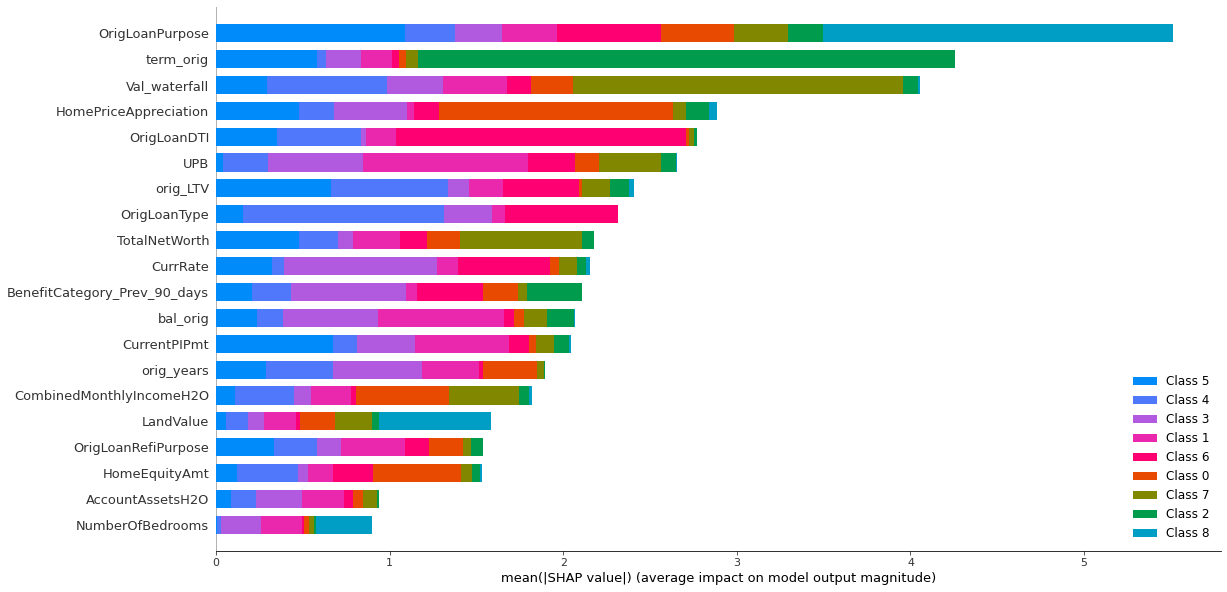

In [83]:
shap_values_km_8 = explainer_km_8.shap_values(lgbm_X_8_df)
shap.summary_plot(shap_values_km_8, lgbm_X_8_df, plot_type="bar", plot_size=(18, 10))